### LASSO parameter range experiments, single gene

`scikit-learn` has two different implementations of logistic regression: [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (using the `liblinear` coordinate descent optimizer) and [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (using stochastic gradient descent for optimization).

In this script we want to compare their performance and model selection dynamics across different levels of regularization, in depth for a single gene in our cancer gene set.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
ll_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_ll_lr_range', 'gene'
)

sgd_results_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'results', 'optimizer_compare_sgd_lr_constant_search', 'gene'
)

plot_gene = 'ERBB2'
metric = 'aupr'

output_plots = False
output_plots_dir = os.path.join(
    cfg.repo_root, '01_stratified_classification', 'optimizers_plots'
)

### Get nonzero coefficient information for each lasso penalty

In [3]:
ll_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
ll_nz_coefs_df = pd.DataFrame(
    ll_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
ll_nz_coefs_df.lasso_param = ll_nz_coefs_df.lasso_param.astype(float)
ll_nz_coefs_df = ll_nz_coefs_df[ll_nz_coefs_df.gene == plot_gene].copy()
ll_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,ERBB2,classify,31600.0,42,0,15258
1,ERBB2,classify,31600.0,42,1,15193
2,ERBB2,classify,31600.0,42,2,15242
3,ERBB2,classify,31600.0,42,3,15244
4,ERBB2,classify,10000.0,1,0,14667


In [4]:
sgd_nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
sgd_nz_coefs_df = pd.DataFrame(
    sgd_nz_coefs_df,
    columns=['gene', 'signal', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
sgd_nz_coefs_df.lasso_param = sgd_nz_coefs_df.lasso_param.astype(float)
sgd_nz_coefs_df = sgd_nz_coefs_df[sgd_nz_coefs_df.gene == plot_gene].copy()
sgd_nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs
0,ERBB2,classify,0.000316,1,0,14282
1,ERBB2,classify,0.000316,1,1,14235
2,ERBB2,classify,0.000316,1,2,14277
3,ERBB2,classify,0.000316,1,3,14265
4,ERBB2,classify,0.000316,42,0,14276


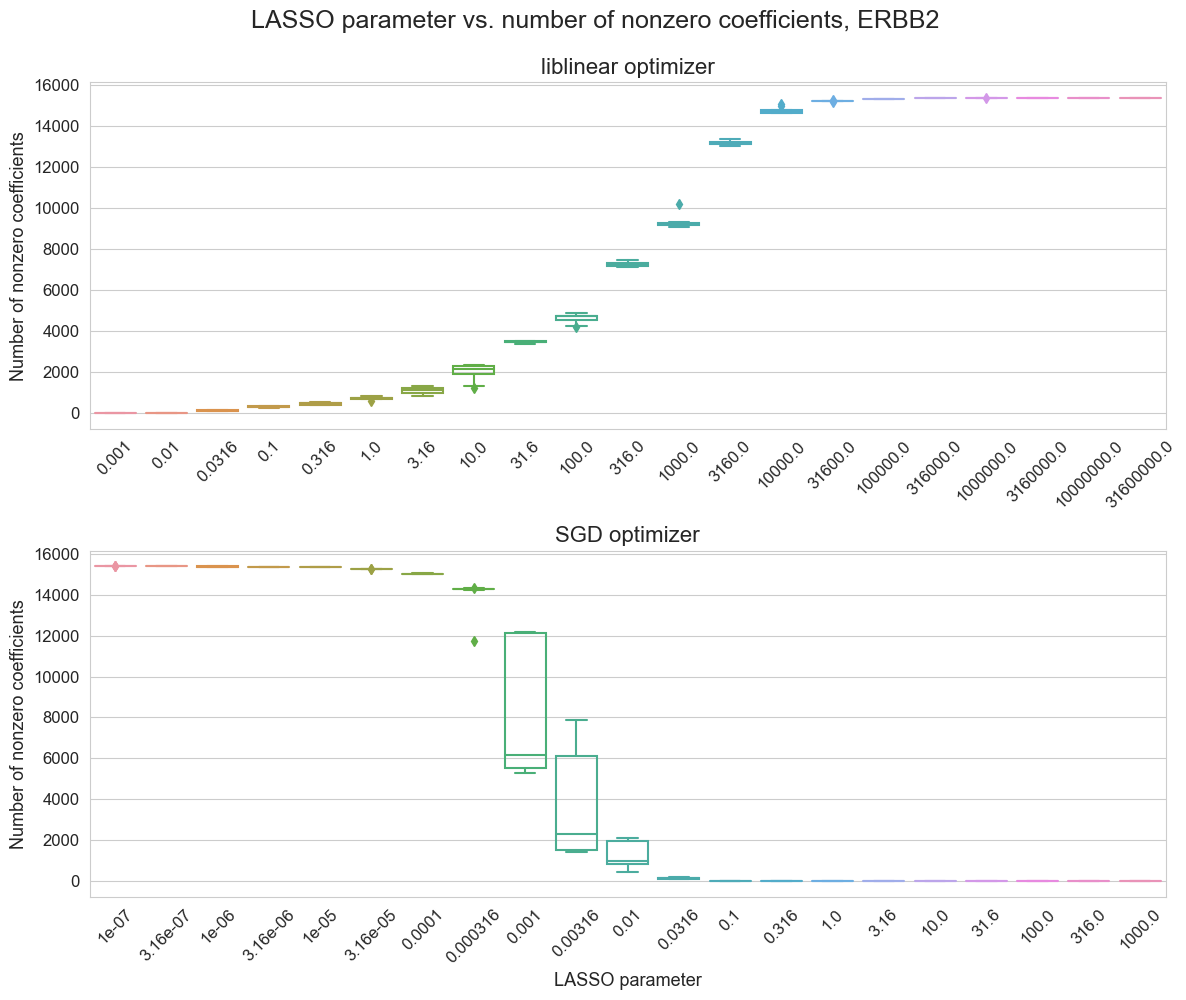

In [5]:
sns.set({'figure.figsize': (12, 10)})
sns.set_style('whitegrid')

fig, axarr = plt.subplots(2, 1)

sns.boxplot(
    data=ll_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[0]
)
axarr[0].set_title('liblinear optimizer', size=16)
axarr[0].set_xlabel('')
axarr[0].set_ylabel('Number of nonzero coefficients', size=13)
axarr[0].tick_params(axis='both', labelsize=12)
axarr[0].tick_params(axis='x', rotation=45)

sns.boxplot(
    data=sgd_nz_coefs_df.sort_values(by=['lasso_param']),
    x='lasso_param', y='nz_coefs', ax=axarr[1]
)
axarr[1].set_title('SGD optimizer', size=16)
axarr[1].set_xlabel('LASSO parameter', size=13)
axarr[1].set_ylabel('Number of nonzero coefficients', size=13)
axarr[1].tick_params(axis='both', labelsize=12)
axarr[1].tick_params(axis='x', rotation=45)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
def color_boxes(ax):
    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()
        patch.set_edgecolor(col)
        patch.set_facecolor('None')

        # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # loop over them here, and use the same color as above
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
            line.set_mfc(col)  # facecolor of fliers
            line.set_mec(col)  # edgecolor of fliers
            
color_boxes(axarr[0])
color_boxes(axarr[1])

plt.suptitle(
    f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}',
    size=18, y=0.995
)

plt.tight_layout()

if output_plots:
    os.makedirs(output_plots_dir, exist_ok=True)
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefs_count.svg'), bbox_inches='tight')

### Get coefficient magnitude information for each lasso penalty

In [6]:
ll_sum_coefs_df = []
sgd_sum_coefs_df = []

for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        ll_sum_coefs_df.append(['liblinear', seed, fold_no, lasso_param,
                                np.sum(np.absolute(list(zip(*coefs))[1]))+1])
        
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        sgd_sum_coefs_df.append(['SGD', seed, fold_no, lasso_param,
                                 np.sum(np.absolute(list(zip(*coefs))[1]))+1])
    
ll_sum_coefs_df = pd.DataFrame(
    ll_sum_coefs_df,
    columns=['optimizer', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)
sgd_sum_coefs_df = pd.DataFrame(
    sgd_sum_coefs_df,
    columns=['optimizer', 'seed', 'fold', 'lasso_param', 'sum_coefs']
)
all_coefs_df = pd.concat((ll_sum_coefs_df, sgd_sum_coefs_df)).reset_index(drop=True)
all_coefs_df.lasso_param = all_coefs_df.lasso_param.astype(float)
all_coefs_df.sort_values(by='lasso_param')

print(all_coefs_df.optimizer.unique())
print(all_coefs_df.shape)
all_coefs_df.head()

['liblinear' 'SGD']
(336, 5)


,optimizer,seed,fold,lasso_param,sum_coefs
0,liblinear,42,0,31600.0,510.346032
1,liblinear,42,1,31600.0,545.843877
2,liblinear,42,2,31600.0,489.564855
3,liblinear,42,3,31600.0,465.591931
4,liblinear,1,0,10000.0,479.478456


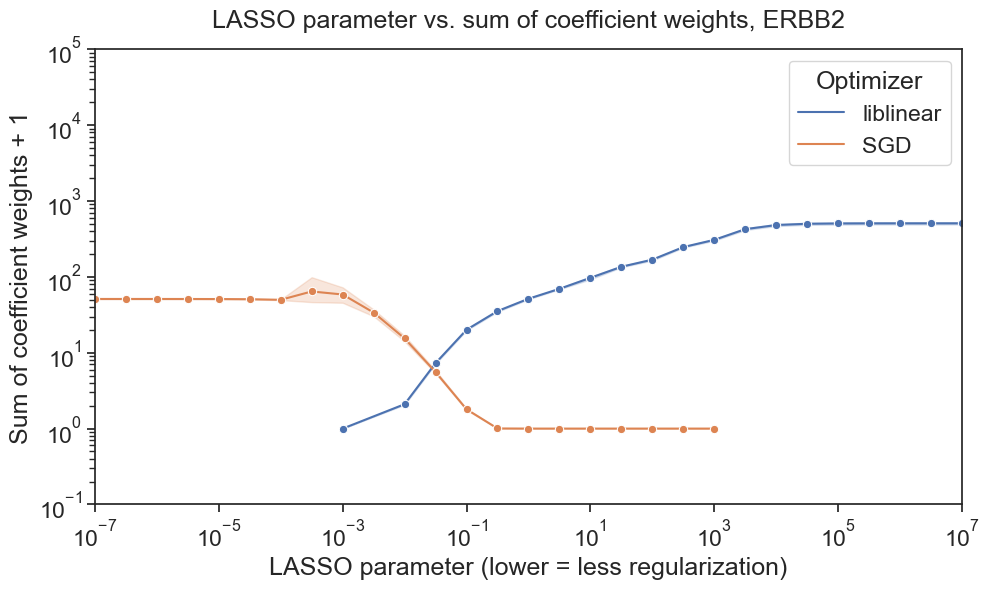

In [7]:
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.lineplot(
        data=all_coefs_df,
        x='lasso_param', y='sum_coefs', hue='optimizer',
        hue_order=['liblinear', 'SGD'], marker='o'
    )
    g.set(xscale='log', yscale='log', xlim=(10e-8, 10e6), ylim=(10e-2, 10e4))
    g.set_xlabel('LASSO parameter (lower = less regularization)')
    g.set_ylabel('Sum of coefficient weights + 1')
    plt.legend(title='Optimizer')
    plt.title(f'LASSO parameter vs. sum of coefficient weights, {plot_gene}', y=1.03)

plt.tight_layout()

In [8]:
# plot coef magnitudes on same axis
# C = 1 / alpha, so we can just invert one of the parameter axes
all_coefs_df['param_same_axis'] = all_coefs_df.lasso_param

sgd_params = all_coefs_df.loc[all_coefs_df.optimizer == 'SGD', 'lasso_param']
(all_coefs_df
   .loc[all_coefs_df.optimizer == 'SGD', 'param_same_axis'] 
) = 1 / sgd_params

print(all_coefs_df.param_same_axis.sort_values().unique())

[1.00000000e-03 3.16455696e-03 1.00000000e-02 3.16000000e-02
 3.16455696e-02 1.00000000e-01 3.16000000e-01 3.16455696e-01
 1.00000000e+00 3.16000000e+00 3.16455696e+00 1.00000000e+01
 3.16000000e+01 3.16455696e+01 1.00000000e+02 3.16000000e+02
 3.16455696e+02 1.00000000e+03 3.16000000e+03 3.16455696e+03
 1.00000000e+04 3.16000000e+04 3.16455696e+04 1.00000000e+05
 1.00000000e+05 3.16000000e+05 3.16455696e+05 1.00000000e+06
 3.16000000e+06 3.16455696e+06 1.00000000e+07 3.16000000e+07]


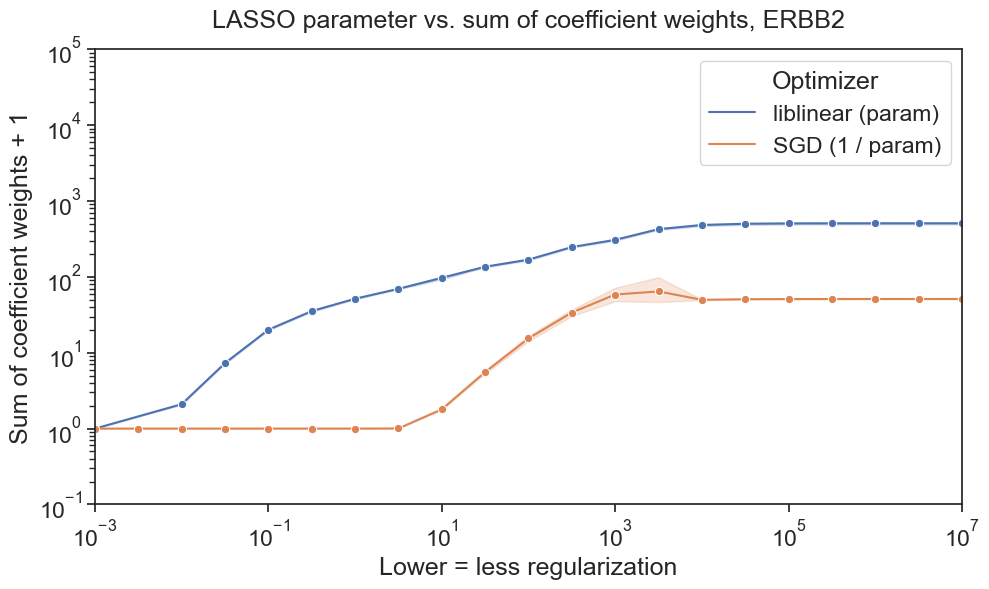

In [9]:
sns.set({'figure.figsize': (10, 6)})
sns.set_style('ticks')

with sns.plotting_context('notebook', font_scale=1.5):
    g = sns.lineplot(
        data=all_coefs_df,
        x='param_same_axis', y='sum_coefs', hue='optimizer',
        hue_order=['liblinear', 'SGD'], marker='o'
    )
    g.set(xscale='log', yscale='log', xlim=(10e-4, 10e6), ylim=(10e-2, 10e4))
    g.set_xlabel('Lower = less regularization')
    g.set_ylabel('Sum of coefficient weights + 1')
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = ['liblinear (param)', r'SGD (1 / param)']
    plt.legend(title='Optimizer', handles=handles, labels=new_labels)
    plt.title(f'LASSO parameter vs. sum of coefficient weights, {plot_gene}', y=1.03)

plt.tight_layout()

### Get performance information for each lasso penalty

In [10]:
ll_perf_df = au.load_prediction_results_lasso_range(ll_results_dir,
                                                    'stratified',
                                                    gene=plot_gene)
ll_perf_df = (
    ll_perf_df[ll_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
ll_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,1.00000,1.00000,ERBB2,signal,1,train,0,10.0
1,0.85001,0.65729,ERBB2,signal,1,test,0,10.0
2,0.82651,0.61910,ERBB2,signal,1,cv,0,10.0
3,1.00000,1.00000,ERBB2,signal,1,train,1,10.0
4,0.85250,0.66341,ERBB2,signal,1,test,1,10.0


In [11]:
sgd_perf_df = au.load_prediction_results_lasso_range(sgd_results_dir,
                                                     'stratified',
                                                     gene=plot_gene)
sgd_perf_df = (
    sgd_perf_df[sgd_perf_df.gene == plot_gene]
    .drop(columns=['holdout_cancer_type', 'experiment'])
    .copy()
)
sgd_perf_df.head()

,auroc,aupr,gene,signal,seed,data_type,fold,lasso_param
0,0.84829,0.71651,ERBB2,signal,42,train,0,0.316
1,0.88326,0.71841,ERBB2,signal,42,test,0,0.316
2,0.89563,0.75368,ERBB2,signal,42,cv,0,0.316
3,0.83919,0.66425,ERBB2,signal,42,train,1,0.316
4,0.84202,0.71118,ERBB2,signal,42,test,1,0.316


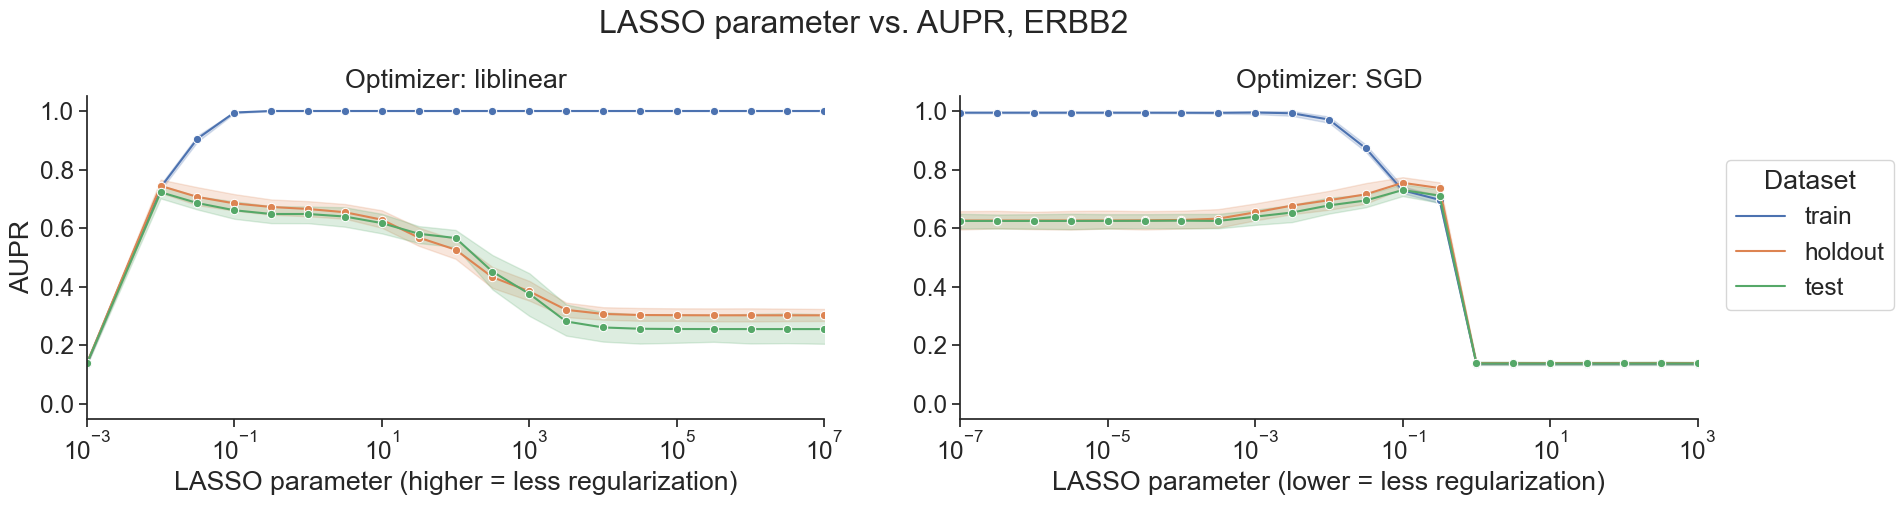

In [12]:
sns.set_style('ticks')

ll_plot_df = (
    ll_perf_df[(ll_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
ll_plot_df.lasso_param = ll_plot_df.lasso_param.astype(float)

sgd_plot_df = (
    sgd_perf_df[(sgd_perf_df.signal == 'signal')]
      .sort_values(by=['lasso_param'])
      .reset_index(drop=True)
)
sgd_plot_df.lasso_param = sgd_plot_df.lasso_param.astype(float)

ll_plot_df['optimizer'] = 'liblinear'
sgd_plot_df['optimizer'] = 'SGD'

plot_df = pd.concat((ll_plot_df, sgd_plot_df))

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o', kind='line', col='optimizer',
        col_wrap=2, height=5, aspect=1.6,
        facet_kws={'sharex': False, 'sharey': False}
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.axes[0].set_xlabel('LASSO parameter (higher = less regularization)')
    g.axes[0].set_xlim((10e-4, 10e6))
    g.axes[0].set_ylim((-0.05, 1.05))
    g.axes[1].set_xlabel('LASSO parameter (lower = less regularization)')
    g.axes[1].set_xlim((10e-8, 10e2))
    g.axes[1].set_ylim((-0.05, 1.05))
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.045, 0.55], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['train', 'holdout', 'test']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    g.set_titles('Optimizer: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.0)

plt.tight_layout(w_pad=5)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_parameter_vs_perf.svg'), bbox_inches='tight')

### Plot coefficient magnitudes

Even though SGD seems to have lots of nonzero coefficients, it's possible that lots of them are close to 0, or effectively 0. We'll plot the coefficient magnitudes on the same axis as the liblinear coefficients, to get a sense of this.

In [13]:
# plot coefficient distributions for this seed/fold
plot_seed = 42
plot_fold = 0

In [14]:
ll_nz_coefs_df['optimizer'] = 'liblinear'
sgd_nz_coefs_df['optimizer'] = 'SGD'

nz_coefs_df = pd.concat((ll_nz_coefs_df, sgd_nz_coefs_df))
nz_coefs_df.head()

,gene,signal,lasso_param,seed,fold,nz_coefs,optimizer
0,ERBB2,classify,31600.0,42,0,15258,liblinear
1,ERBB2,classify,31600.0,42,1,15193,liblinear
2,ERBB2,classify,31600.0,42,2,15242,liblinear
3,ERBB2,classify,31600.0,42,3,15244,liblinear
4,ERBB2,classify,10000.0,1,0,14667,liblinear


In [15]:
perf_coefs_df = (plot_df
    .merge(nz_coefs_df,
           left_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'],
           right_on=['gene', 'optimizer', 'lasso_param', 'seed', 'fold'])
)

print(perf_coefs_df.shape)
perf_coefs_df.head()

(1008, 11)


,auroc,aupr,gene,signal_x,seed,data_type,fold,lasso_param,optimizer,signal_y,nz_coefs
0,0.5,0.14152,ERBB2,signal,42,cv,3,0.001,liblinear,classify,0
1,0.5,0.13707,ERBB2,signal,42,train,3,0.001,liblinear,classify,0
2,0.5,0.13707,ERBB2,signal,42,test,3,0.001,liblinear,classify,0
3,0.5,0.14308,ERBB2,signal,42,cv,1,0.001,liblinear,classify,0
4,0.5,0.13084,ERBB2,signal,42,test,1,0.001,liblinear,classify,0


In [16]:
# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
ll_mean_perf_df = (
  ll_perf_df[(ll_perf_df.data_type == 'cv') &
             (ll_perf_df.signal == 'signal')]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
      .sort_values(by='mean_aupr', ascending=False)
      .reset_index()
)
ll_mean_perf_df.head()

,lasso_param,mean_auroc,mean_aupr
0,0.01,0.875019,0.744407
1,0.0316,0.858704,0.706560
2,0.1,0.853592,0.684625
3,0.316,0.851164,0.672346
4,1.0,0.851786,0.665529


In [17]:
# get top-performing lasso param for each gene,
# based on mean performance across seeds/folds
sgd_mean_perf_df = (
  sgd_perf_df[(sgd_perf_df.data_type == 'cv') &
              (sgd_perf_df.signal == 'signal')]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
      .sort_values(by='mean_aupr', ascending=False)
      .reset_index()
)
sgd_mean_perf_df.head()

,lasso_param,mean_auroc,mean_aupr
0,0.1,0.882005,0.754876
1,0.316,0.873656,0.736936
2,0.0316,0.870868,0.715527
3,0.01,0.864575,0.695401
4,0.00316,0.863046,0.676999


In [18]:
ll_top_lasso_param = ll_mean_perf_df.iloc[0, :].lasso_param
sgd_top_lasso_param = sgd_mean_perf_df.iloc[0, :].lasso_param
print(ll_top_lasso_param, sgd_top_lasso_param)

0.01 0.1


In [19]:
# get coefficient info for liblinear
for coef_info in au.generate_nonzero_coefficients_lasso_range(ll_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    if seed != plot_seed or lasso_param != ll_top_lasso_param:
        continue
    for fold_no, coefs in enumerate(coefs_list):
        if fold_no != plot_fold:
            continue
        ll_coefs_df = coefs
        
ll_coefs_df = (
    pd.DataFrame(ll_coefs_df)
      .rename(columns={0: 'feature', 1: 'coef'})
)
ll_coefs_df['optimizer'] = 'liblinear'
ll_coefs_df['abs+1'] = abs(ll_coefs_df.coef) + 1
ll_coefs_df.sort_values(by='abs+1', ascending=False).head(10)

,feature,coef,optimizer,abs+1
0,2064,0.652450,liblinear,1.652450
1,5709,0.109810,liblinear,1.109810
2,7153,0.083597,liblinear,1.083597
3,54883,0.040211,liblinear,1.040211
4,116285,0.039259,liblinear,1.039259
5,94134,0.030665,liblinear,1.030665
6,9349,0.025615,liblinear,1.025615
7,log10_mut,-0.025274,liblinear,1.025274
8,331,0.018164,liblinear,1.018164
9,3927,0.010106,liblinear,1.010106


In [20]:
# get coefficient info for sgd
for coef_info in au.generate_nonzero_coefficients_lasso_range(sgd_results_dir,
                                                              gene=plot_gene,
                                                              nonzero_only=False):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    if seed != plot_seed or lasso_param != sgd_top_lasso_param:
        continue
        continue
    for fold_no, coefs in enumerate(coefs_list):
        if fold_no != plot_fold:
            continue
        sgd_coefs_df = coefs
        
sgd_coefs_df = (
    pd.DataFrame(sgd_coefs_df)
      .rename(columns={0: 'feature', 1: 'coef'})
)
sgd_coefs_df['optimizer'] = 'SGD'
sgd_coefs_df['abs+1'] = abs(sgd_coefs_df.coef) + 1
sgd_coefs_df.sort_values(by='abs+1', ascending=False).head(10)

,feature,coef,optimizer,abs+1
0,2064,0.550330,SGD,1.550330
1,5709,0.096308,SGD,1.096308
2,7153,0.062311,SGD,1.062311
3,54883,0.047415,SGD,1.047415
4,116285,0.038018,SGD,1.038018
5,94134,0.031464,SGD,1.031464
6,339287,0.017441,SGD,1.017441
7,94103,0.003921,SGD,1.003921
10251,2597,0.000000,SGD,1.000000
10256,3106,0.000000,SGD,1.000000


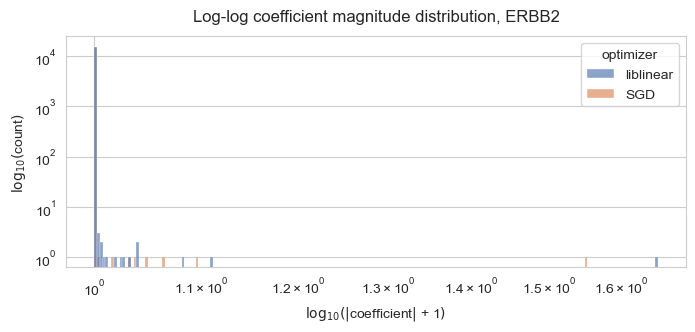

In [21]:
sns.set({'figure.figsize': (8, 3)})
sns.set_style('whitegrid')

coefs_df = pd.concat((ll_coefs_df, sgd_coefs_df)).reset_index(drop=True)

sns.histplot(data=coefs_df, x='abs+1', hue='optimizer', bins=200,
             log_scale=(True, True), alpha=0.65)
plt.xlabel(r'$\log_{10}(|$coefficient$|$ + 1$)$')
plt.ylabel(r'$\log_{10}($count$)$')
plt.title(f'Log-log coefficient magnitude distribution, {plot_gene}', y=1.03)

if output_plots:
    plt.savefig(os.path.join(output_plots_dir, f'{gene}_coefficient_magnitudes.svg'),
                bbox_inches='tight')

Text(0.5, 0, 'Coefficient')

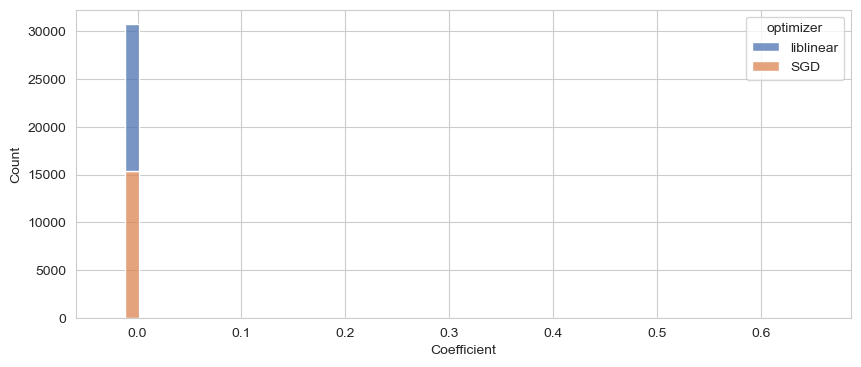

In [22]:
sns.set({'figure.figsize': (10, 4)})
sns.set_style('whitegrid')

coefs_df = pd.concat((ll_coefs_df, sgd_coefs_df)).reset_index(drop=True)

sns.histplot(data=coefs_df, x='coef', hue='optimizer', bins=50, multiple='stack')
plt.xlabel('Coefficient')